In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

from matplotlib.pyplot import *
%matplotlib notebook
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
from sklearn import model_selection
from theano import shared, config

from deepensemble.utils import load_data, plot_data_training_ensemble
from deepensemble.utils.utils_classifiers import get_index_label_classes, translate_target
from deepensemble.utils.utils_functions import ActivationFunctions, ITLFunctions
from deepensemble.utils.utils_models import get_ensembleCIP_model
from deepensemble.utils.update_functions import sgd
from deepensemble.utils.score_functions import mutual_information_cs, mutual_information_ed, mutual_information_parzen

In [2]:
#############################################################################################################
# Load Data
#############################################################################################################
data_db = load_data('australian_scale', data_home='../../data', normalize=False)
data_input, data_target, classes_labels, name_db, desc, col_names = data_db

# Generate testing and training sets
input_train, input_test, target_train, target_test = \
    model_selection.train_test_split(data_input, data_target, test_size=0.3)

In [3]:
#############################################################################################################
# Define Parameters nets
#############################################################################################################

n_features = data_input.shape[1]
n_classes = len(classes_labels)

n_output = n_classes
n_inputs = n_features

n_neurons_model = int(0.5 * (n_output + n_inputs))

n_ensemble_models = 1
fn_activation1 = ActivationFunctions.sigmoid
fn_activation2 = ActivationFunctions.sigmoid

y = get_index_label_classes(translate_target(data_target, classes_labels))
s = ITLFunctions.silverman(shared(np.array(y))).eval()

list_scores = [
    {'fun_score': mutual_information_parzen, 'name': 'Información Mutua'},
    {'fun_score': mutual_information_cs, 'name': 'QMI CS'},
    {'fun_score': mutual_information_ed, 'name': 'QMI ED'}
]

In [6]:
#############################################################################################################
# Testing
#############################################################################################################

# ==========< Ensemble  CIP   >==============================================================================
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIP',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    classification=True,
                                    is_cip_full=False,
                                    classes_labels=classes_labels,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.3, lamb=0.3, s=s,
                                    lsp=1.5, lsm=0.5,
                                    bias_layer=False, mse_first_epoch=False, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.1},  # maximization
                                    list_scores=list_scores
                                    )

ensembleCIP.compile(fast=False)

max_epoch = 500
args_train = {'max_epoch': max_epoch, 'batch_size': 32, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

metrics = ensembleCIP.fit(input_train, target_train, **args_train)

Start Compile Ensamble CIP  - elapsed: 3.88 [s]
Ensamble CIP - fold: 1, epoch:[####################] 500/500 elapsed: 7.84[s] - left: 0.00[s] | score: 0.8606 / 0.9062


<IPython.core.display.Javascript object>


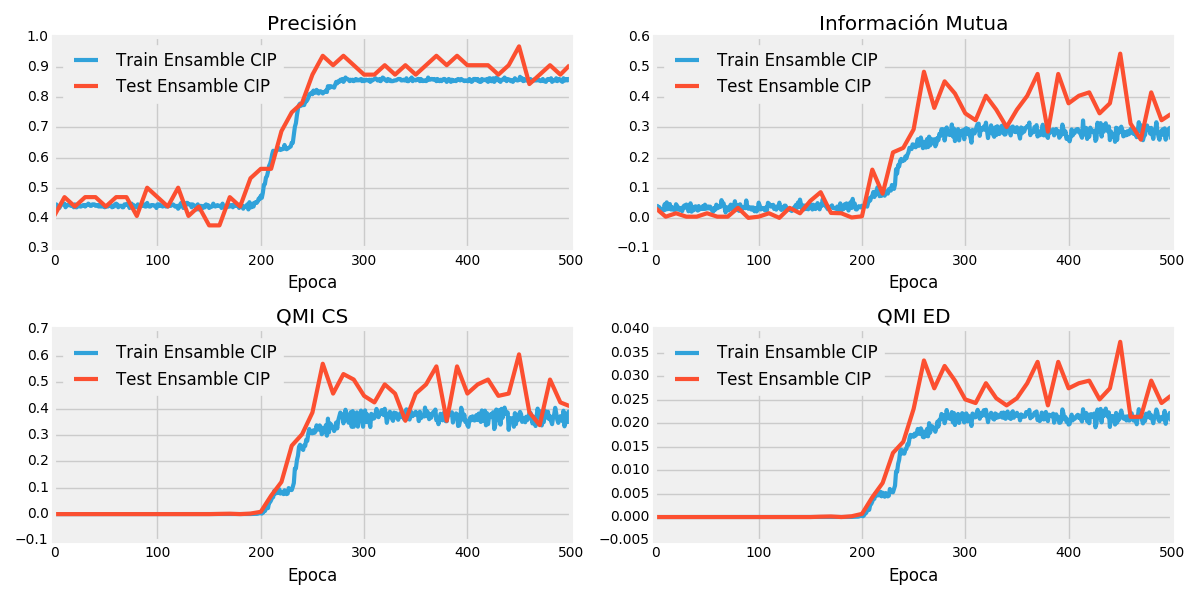

In [7]:
import matplotlib.pylab as plt

from deepensemble.utils.utils_plot import ConfigPlot

ConfigPlot().set_size_font(10)

metrics.plot_scores(max_epoch=max_epoch, title='')

plt.tight_layout()

plt.show()